### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [61]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [62]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [63]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['Priority'])


In [64]:
#Cleaning Description using short description for observations recorded by Netcool Alerting tool
data['Description'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)

In [65]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,AS MEDICAL APP CHINA L2,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36


In [66]:
data.Priority.value_counts()

Priority 4    33383
Priority 3    22495
Priority 2      194
Priority 1        4
Name: Priority, dtype: int64

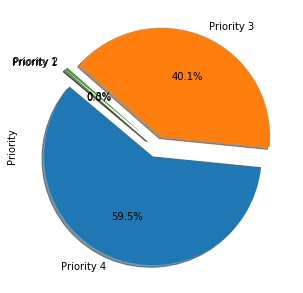

In [67]:
chart=data.Priority.value_counts()
explode = (0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Priority', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [76]:
from sklearn.utils import resample

df_1 = data[data.Priority=='Priority 4']
df_2 = data[data.Priority=='Priority 3']

df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=22495,  # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=22495,  # to match majority class
                                 random_state=123) # reproducible results



# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled])

In [77]:
data.Priority.value_counts()

Priority 4    22495
Priority 3    22495
Name: Priority, dtype: int64

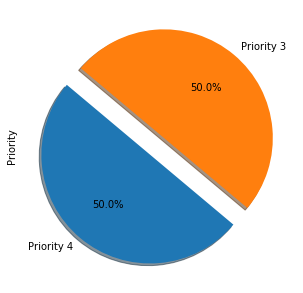

In [79]:
chart=data.Priority.value_counts()
explode = (0.1, 0.1)
plot = chart.plot.pie(y='Priority', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [80]:
data['target_prt'] = data.Priority.astype('category').cat.codes

In [81]:
labels_prt = data.Priority.astype('category').cat.categories

In [82]:
df = pd.DataFrame(labels_prt) 
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_prt.csv')

In [83]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_prt
24537,INC000020572802,"For dim_slt_id=2316, following tasks violated ...",TASK_END_DELAY - SLT ID 2316,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,DEPUY SYNTHES – US – BI – QLIK,...,Closed Complete,Connectivity,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,MRUGANG PURAO (643021133),KB000010080053,NaN,2019-08-01 4:00,2019-08-02 8:42,1
48264,INC000019357291,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Application,Job Failure,Low,Limited,ONEMD D&A CLINICAL DIA - PROD,...,Closed Complete,Physical environmental failure,NaN,DATA AND ANALYTICS RR TCS,ALOK DAS (643014408),KB000010047671,GLOBAL,2018-11-19 19:15,2018-11-22 2:17,1
30708,INC000018820683,I have the required user acess rights to AWSAD...,Connectivity issue with EC2 server,DIOGO BALTAZAR (702260239),Priority 4,Software,Enterprise software,Low,Limited,ONEMD COMMERCIAL ANALYTICS - PROD,...,Closed Complete,User knowledge or training error,Lagoas Park,AS_MDD_EMEA_COMMANLYCS_L2,SNEHAJIT BISWAS (643010176),KB000010041252,EMEA,2018-07-31 11:01,2018-08-02 10:21,1
24077,INC000020409726,When did this issue begin?:\r\n\r\nWho is this...,UCN is mapped to the default unknown 9999998 i...,JACOB VEATCH (196099),Priority 4,Application,Data Issue,Medium,Limited,ONEMD COMMERCIAL DATA WAREHOUSE - PROD,...,Closed Complete,Data Issue,NA US IN WARSAW,DATA AND ANALYTICS RR LTI,JANARDHANAN DHANDAPANI KUTTY (643019823),KB000010076928,NaN,2019-06-28 15:08,2019-07-10 21:06,1
12562,INC000017608615,GFS-FP&A-FINANCIAL PLANNING TM1 Finance GRM TM...,Software - J&J business applications: Data mis...,JONIZEN ABING (152026114),Priority 4,Software,Enterprise software,Medium,Limited,GFS-FP&A-FINANCIAL PLANNING TM1,...,Closed Complete,Data Issue,ASPAC PH PARANAQUE,GFS-FP&A COE TM1,JONATHAN YAU (1043412),NaN,GLOBAL,2017-11-10 14:01,2017-11-13 10:28,1


In [84]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [85]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,30,60,130, np.inf], labels=['0-10', '10-30', '30-60','60-130' ,'>130'])


In [86]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [87]:
word_distribution.head()

,bins,counts
0,0-10,10109
1,10-30,19155
2,30-60,9697
3,60-130,5106
4,>130,923


Text(0.5, 1.0, 'Word distribution per bin')

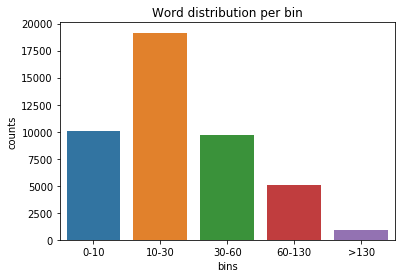

In [88]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [89]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_prt,num_words,bins
24537,INC000020572802,"For dim_slt_id=2316, following tasks violated ...",TASK_END_DELAY - SLT ID 2316,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,DEPUY SYNTHES – US – BI – QLIK,...,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,MRUGANG PURAO (643021133),KB000010080053,NaN,2019-08-01 4:00,2019-08-02 8:42,1,9,0-10
48264,INC000019357291,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Application,Job Failure,Low,Limited,ONEMD D&A CLINICAL DIA - PROD,...,NaN,DATA AND ANALYTICS RR TCS,ALOK DAS (643014408),KB000010047671,GLOBAL,2018-11-19 19:15,2018-11-22 2:17,1,18,10-30
30708,INC000018820683,I have the required user acess rights to AWSAD...,Connectivity issue with EC2 server,DIOGO BALTAZAR (702260239),Priority 4,Software,Enterprise software,Low,Limited,ONEMD COMMERCIAL ANALYTICS - PROD,...,Lagoas Park,AS_MDD_EMEA_COMMANLYCS_L2,SNEHAJIT BISWAS (643010176),KB000010041252,EMEA,2018-07-31 11:01,2018-08-02 10:21,1,44,30-60
24077,INC000020409726,When did this issue begin?:\r\n\r\nWho is this...,UCN is mapped to the default unknown 9999998 i...,JACOB VEATCH (196099),Priority 4,Application,Data Issue,Medium,Limited,ONEMD COMMERCIAL DATA WAREHOUSE - PROD,...,NA US IN WARSAW,DATA AND ANALYTICS RR LTI,JANARDHANAN DHANDAPANI KUTTY (643019823),KB000010076928,NaN,2019-06-28 15:08,2019-07-10 21:06,1,40,30-60
12562,INC000017608615,GFS-FP&A-FINANCIAL PLANNING TM1 Finance GRM TM...,Software - J&J business applications: Data mis...,JONIZEN ABING (152026114),Priority 4,Software,Enterprise software,Medium,Limited,GFS-FP&A-FINANCIAL PLANNING TM1,...,ASPAC PH PARANAQUE,GFS-FP&A COE TM1,JONATHAN YAU (1043412),NaN,GLOBAL,2017-11-10 14:01,2017-11-13 10:28,1,17,10-30


In [90]:
num_class_prt = len(np.unique(data.Priority.values))
y_prt = data['target_prt'].values


## Topic Modelling

In [91]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [92]:
data['Description'] = data['Description'].astype(str)

In [93]:
type(data['Description'])

pandas.core.series.Series

In [94]:
data_description = data.Description.values

In [95]:
type(data_description)

numpy.ndarray

In [96]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

000000000 11.021070568189845
000000000000019445 11.021070568189845
000000000000410989 11.021070568189845
000000000000410990 11.021070568189845
000000000000413030 11.021070568189845
000000000000413031 11.021070568189845
000000000000415798 11.021070568189845
000000000000416209 11.021070568189845
000000000000417710 11.021070568189845
000000000015061379 11.021070568189845
000000000019804817 11.021070568189845
000000000019804824 11.021070568189845
000000000043309730 11.021070568189845
000000000100369500 11.021070568189845
000000000304882800 11.021070568189845
000000000510007127 11.021070568189845
000000000523062000 11.021070568189845
000000000523062500 11.021070568189845
000000000523063500 11.021070568189845
000000000523065500 11.021070568189845
000000000527806000 11.021070568189845
000000000529447900 11.021070568189845
000000000529448000 11.021070568189845
000000010000000d0000000d 11.021070568189845
0000000376 11.021070568189845
0000002265 11.021070568189845
000000_0 11.021070568189845
000

1100b 11.021070568189845
1100c 11.021070568189845
110256 11.021070568189845
110302 11.021070568189845
1106 11.021070568189845
110605 11.021070568189845
1107 11.021070568189845
1110 11.021070568189845
111110109 11.021070568189845
111112 11.021070568189845
111226 11.021070568189845
11126 11.021070568189845
111770 11.021070568189845
1118 11.021070568189845
11197519 11.021070568189845
11197581 11.021070568189845
11208 11.021070568189845
112088 11.021070568189845
112403 11.021070568189845
11262 11.021070568189845
112673 11.021070568189845
1128 11.021070568189845
11286 11.021070568189845
1129 11.021070568189845
113001898 11.021070568189845
1131554 11.021070568189845
113301 11.021070568189845
113317 11.021070568189845
11351204 11.021070568189845
113660 11.021070568189845
1140e502a59c 11.021070568189845
114110001 11.021070568189845
114190 11.021070568189845
114190001 11.021070568189845
11480898 11.021070568189845
1150 11.021070568189845
1152084551 11.021070568189845
11532 11.021070568189845
11

210995 11.021070568189845
210b 11.021070568189845
2110 11.021070568189845
21100 11.021070568189845
2110001 11.021070568189845
2110005 11.021070568189845
2110007 11.021070568189845
21122018 11.021070568189845
21141 11.021070568189845
21142 11.021070568189845
21143 11.021070568189845
211430 11.021070568189845
2115 11.021070568189845
211577 11.021070568189845
2117 11.021070568189845
2121 11.021070568189845
212264 11.021070568189845
21279 11.021070568189845
21316 11.021070568189845
213224 11.021070568189845
213301 11.021070568189845
21330608so 11.021070568189845
213514 11.021070568189845
213822 11.021070568189845
213960003 11.021070568189845
214001 11.021070568189845
214095237066 11.021070568189845
2141 11.021070568189845
214112 11.021070568189845
2142 11.021070568189845
21422599 11.021070568189845
2143 11.021070568189845
21437478 11.021070568189845
2144 11.021070568189845
2145 11.021070568189845
214518 11.021070568189845
2146 11.021070568189845
2147 11.021070568189845
214786 11.0210705681

3e6400 11.021070568189845
3e6919c100000000 11.021070568189845
3e7222 11.021070568189845
3e7239 11.021070568189845
3e7560 11.021070568189845
3e7684 11.021070568189845
3e8085 11.021070568189845
3e8505 11.021070568189845
3e9890 11.021070568189845
3ecarefree 11.021070568189845
3eeb 11.021070568189845
3f12 11.021070568189845
3f1281 11.021070568189845
3f1951 11.021070568189845
3f28 11.021070568189845
3f348 11.021070568189845
3f6644 11.021070568189845
3f6882 11.021070568189845
3f7052 11.021070568189845
3f8430 11.021070568189845
3f8939 11.021070568189845
3f8940 11.021070568189845
3f8965 11.021070568189845
3fretry 11.021070568189845
3frootfolder 11.021070568189845
3fsysparm_article 11.021070568189845
3g1066 11.021070568189845
3g1631 11.021070568189845
3g1916 11.021070568189845
3g233 11.021070568189845
3g3313 11.021070568189845
3g3462 11.021070568189845
3g3590 11.021070568189845
3g3771 11.021070568189845
3g392 11.021070568189845
3g422 11.021070568189845
3g4437 11.021070568189845
3g5228 11.021070

49c4 11.021070568189845
49cd 11.021070568189845
49f55bec3e6da873 11.021070568189845
49k 11.021070568189845
49madhu 11.021070568189845
4_4 11.021070568189845
4a4f 11.021070568189845
4aee 11.021070568189845
4af561167826 11.021070568189845
4b21 11.021070568189845
4b74 11.021070568189845
4b798b6b 11.021070568189845
4bbf 11.021070568189845
4c0c 11.021070568189845
4c763009b0174bee82539db6b5a55f7d_0vendor_text_bw_bpc330_emea 11.021070568189845
4c928966 11.021070568189845
4cb1 11.021070568189845
4cc9 11.021070568189845
4d2c 11.021070568189845
4d3d 11.021070568189845
4d87 11.021070568189845
4d88 11.021070568189845
4da8 11.021070568189845
4db4 11.021070568189845
4dba 11.021070568189845
4de0b1a9a14c4c73a4feb2881ef5e511_stsd_cb03_lake_dataout 11.021070568189845
4deb 11.021070568189845
4e0c12e2 11.021070568189845
4e0c49088b9e 11.021070568189845
4e25 11.021070568189845
4e2e 11.021070568189845
4e3e 11.021070568189845
4e51 11.021070568189845
4e6b59b6 11.021070568189845
4e6c 11.021070568189845
4ecf30d6

7384 11.021070568189845
7388336 11.021070568189845
7391 11.021070568189845
7394590 11.021070568189845
7395712003 11.021070568189845
7395712055 11.021070568189845
739643302cb 11.021070568189845
7396764 11.021070568189845
7397 11.021070568189845
7398 11.021070568189845
7399846 11.021070568189845
73d1 11.021070568189845
7400000 11.021070568189845
740001 11.021070568189845
7400431 11.021070568189845
7400846074 11.021070568189845
7401085 11.021070568189845
7403594 11.021070568189845
7403598 11.021070568189845
740433067 11.021070568189845
7404629 11.021070568189845
7404632 11.021070568189845
7404633037 11.021070568189845
7405 11.021070568189845
7405961 11.021070568189845
7406330 11.021070568189845
7407002 11.021070568189845
7411 11.021070568189845
7411699 11.021070568189845
7415143 11.021070568189845
7416955 11.021070568189845
7417518010 11.021070568189845
7417518062 11.021070568189845
7421142001 11.021070568189845
7421142034 11.021070568189845
7422 11.021070568189845
7425907045 11.021070568

albany 11.021070568189845
alberta 11.021070568189845
albury 11.021070568189845
alcohol 11.021070568189845
alcune 11.021070568189845
alega 11.021070568189845
alena 11.021070568189845
alerta 11.021070568189845
alessandra 11.021070568189845
alexanader 11.021070568189845
alexandre 11.021070568189845
alfonte 11.021070568189845
algn 11.021070568189845
algum 11.021070568189845
alguma 11.021070568189845
algunas 11.021070568189845
algunos 11.021070568189845
aliased 11.021070568189845
alice 11.021070568189845
alidation 11.021070568189845
aligned_sales 11.021070568189845
alignemnt 11.021070568189845
alignmnet 11.021070568189845
alimentava 11.021070568189845
aline 11.021070568189845
aliniger 11.021070568189845
aller 11.021070568189845
allerdings 11.021070568189845
alleviate 11.021070568189845
allie 11.021070568189845
allign 11.021070568189845
alloc_vol_su 11.021070568189845
alloc_vol_su_uom 11.021070568189845
allowance 11.021070568189845
alm_instantis_projectid_bussrv_appl_vw 11.021070568189845
al

catherinehertl 11.021070568189845
cathleen 11.021070568189845
cathy 11.021070568189845
cato 11.021070568189845
catrysse 11.021070568189845
causa 11.021070568189845
causou 11.021070568189845
cb140 11.021070568189845
cb1e8530 11.021070568189845
cbco001 11.021070568189845
cbe_dist_franc_mon 11.021070568189845
cbrims 11.021070568189845
cc0081s 11.021070568189845
cc1125f10419a7269366f7f950f57b24b07acd64 11.021070568189845
cc3999 11.021070568189845
cc8aa589 11.021070568189845
cc_bal_io_sum 11.021070568189845
cc_bal_sum 11.021070568189845
cc_cd 11.021070568189845
cc_doc_id 11.021070568189845
cc_escsite_asgn 11.021070568189845
cc_fin_sgmnt_hier 11.021070568189845
cc_line 11.021070568189845
ccan 11.021070568189845
ccanada 11.021070568189845
ccannot 11.021070568189845
ccatransaction 11.021070568189845
ccb 11.021070568189845
ccb00015700 11.021070568189845
ccb0ba3059bd 11.021070568189845
ccbal 11.021070568189845
cced 11.021070568189845
cchannel 11.021070568189845
ccl_assert 11.021070568189845
ccla

cuffley 11.021070568189845
cujo 11.021070568189845
cultural 11.021070568189845
culture 11.021070568189845
cumputer 11.021070568189845
curaehealth 11.021070568189845
curator 11.021070568189845
curie 11.021070568189845
currdec 11.021070568189845
currency_code 11.021070568189845
currenly 11.021070568189845
current_date_fl 11.021070568189845
current_sales_locked_le 11.021070568189845
currentmonth 11.021070568189845
currentyr 11.021070568189845
curriculumitem 11.021070568189845
currkey 11.021070568189845
cursor 11.021070568189845
curt 11.021070568189845
cusomters 11.021070568189845
cust_id 11.021070568189845
cust_jnj_id 11.021070568189845
cust_legacy_bill_to 11.021070568189845
cust_legacy_ship_to 11.021070568189845
cust_lgcy_billto 11.021070568189845
cust_nm 11.021070568189845
cust_num 11.021070568189845
cust_req_delivery_day 11.021070568189845
custmdm_s 11.021070568189845
custmgt 11.021070568189845
customer_legacy_bill_to_no 11.021070568189845
customer_legacy_ship_to_no 11.021070568189845


donations 11.021070568189845
donderdag 11.021070568189845
dondonis 11.021070568189845
dongen 11.021070568189845
dongle 11.021070568189845
donki 11.021070568189845
donner 11.021070568189845
donnée 11.021070568189845
dononprepexecutequery 11.021070568189845
donot 11.021070568189845
donqui 11.021070568189845
donwloadable 11.021070568189845
doorgestuurd 11.021070568189845
doorsturen 11.021070568189845
doorverwezen 11.021070568189845
doproceed 11.021070568189845
dora 11.021070568189845
dorina 11.021070568189845
dormir 11.021070568189845
dort 11.021070568189845
dortmund 11.021070568189845
dosent 11.021070568189845
dosisrechner 11.021070568189845
dotted 11.021070568189845
doubleclick 11.021070568189845
doveva 11.021070568189845
dowload 11.021070568189845
dowloaded 11.021070568189845
dowloand 11.021070568189845
downey 11.021070568189845
download_cubes 11.021070568189845
downloadandinstallupdates 11.021070568189845
downloadandinstallupdatesites 11.021070568189845
downloadscript 11.0210705681898

fb_comp_med 11.021070568189845
fbbf7e087f12 11.021070568189845
fbit 11.021070568189845
fbp2019 11.021070568189845
fbpy1 11.021070568189845
fbw 11.021070568189845
fc08 11.021070568189845
fcg 11.021070568189845
fct_actvy 11.021070568189845
fct_amet_hist_load_job 11.021070568189845
fct_amet_ims_hist_load 11.021070568189845
fct_amet_ims_mat 11.021070568189845
fct_amet_ims_mat_job 11.021070568189845
fct_amet_stt_curr_prd 11.021070568189845
fct_amet_stt_orchestration 11.021070568189845
fct_call_clm 11.021070568189845
fct_call_plan 11.021070568189845
fct_call_plan_aggr_nsd 11.021070568189845
fct_calls_aggr_rgn 11.021070568189845
fct_csw_amet 11.021070568189845
fct_dsr 11.021070568189845
fct_imm_specialty_currwk_qc 11.021070568189845
fct_log_content 11.021070568189845
fct_product_decile 11.021070568189845
fct_sales_aggr_rgn 11.021070568189845
fct_sales_aggr_sd 11.021070568189845
fct_sales_cns 11.021070568189845
fct_sales_imm 11.021070568189845
fct_sales_mat_stg 11.021070568189845
fct_sales_mat

ids_vpc_asl_src_job005020 11.021070568189845
ids_vpc_asl_src_job005025 11.021070568189845
ids_vpc_asl_src_job005030 11.021070568189845
ids_vpc_asl_src_job005035 11.021070568189845
ids_vpc_asl_src_job005040 11.021070568189845
ids_vpc_asl_src_job005045 11.021070568189845
ids_vpc_asl_src_job014037 11.021070568189845
ids_vpc_asl_src_net000004 11.021070568189845
ids_vpc_asl_src_net000005 11.021070568189845
ids_vpc_asl_src_net000014 11.021070568189845
ids_vpc_asl_tde_job003001 11.021070568189845
ids_vpc_asl_tde_net000003 11.021070568189845
ids_vpc_etc_lgc_job003015 11.021070568189845
ids_vpc_ica_mnt_job001004 11.021070568189845
ids_vpc_ica_mnt_job001007 11.021070568189845
ids_vpc_ica_mnt_job001010 11.021070568189845
ids_vpc_ica_mnt_job001013 11.021070568189845
ids_vpc_ica_mnt_job001016 11.021070568189845
ids_vpc_ica_mnt_job001022 11.021070568189845
ids_vpc_ica_mnt_job001028 11.021070568189845
ids_vpc_ica_mnt_job001031 11.021070568189845
ids_vpc_ica_mnt_job001034 11.021070568189845
ids_vpc_ic

js_readcalloutresponse 11.021070568189845
jsc2019dashboard 11.021070568189845
jsd_data 11.021070568189845
jsdebug 11.021070568189845
jsonp 11.021070568189845
jspa 11.021070568189845
jstr 11.021070568189845
jt 11.021070568189845
jtds 11.021070568189845
jtdsconnection 11.021070568189845
jte 11.021070568189845
jtr_direct_indirect_sales_rs_int_wrk_daily 11.021070568189845
jtr_dwh_dps_cust_dim_daily 11.021070568189845
jtr_dwh_dps_prod_dim_daily 11.021070568189845
juana 11.021070568189845
jubara 11.021070568189845
juco 11.021070568189845
jui 11.021070568189845
juin 11.021070568189845
jul31 11.021070568189845
july14 11.021070568189845
jumping 11.021070568189845
jumps 11.021070568189845
jun16 11.021070568189845
juneja 11.021070568189845
juni 11.021070568189845
juno 11.021070568189845
junwen 11.021070568189845
jwhale 11.021070568189845
jxl 11.021070568189845
jzhu106 11.021070568189845
k062426 11.021070568189845
k21 11.021070568189845
k28 11.021070568189845
k33 11.021070568189845
k55 11.02107056

mentorsa 11.021070568189845
mequilibrium 11.021070568189845
mera 11.021070568189845
merrillville 11.021070568189845
messagecode 11.021070568189845
messagingexception 11.021070568189845
messsge 11.021070568189845
messy 11.021070568189845
mestre 11.021070568189845
metalogix 11.021070568189845
metatags 11.021070568189845
meterial 11.021070568189845
methodist 11.021070568189845
mettre 11.021070568189845
metwaly 11.021070568189845
meus 11.021070568189845
mezzovico 11.021070568189845
mfay2 11.021070568189845
mfgpro_stg 11.021070568189845
mfid 11.021070568189845
mfv9d5 11.021070568189845
mgmt_daily 11.021070568189845
mgmt_rptg_co_cd 11.021070568189845
mgmt_territory 11.021070568189845
mgmtmaindashboardv3forpoweruser 11.021070568189845
mgrandhi 11.021070568189845
mho21 11.021070568189845
mht 11.021070568189845
michaela 11.021070568189845
michinobu 11.021070568189845
microsite 11.021070568189845
midas 11.021070568189845
mideast 11.021070568189845
midtown 11.021070568189845
midwifeoftheyear 11.0

orchestration_product_summary_report_0_1 11.021070568189845
orchestration_product_summary_report_r 11.021070568189845
ord 11.021070568189845
ord_entry_day 11.021070568189845
ord_line_number 11.021070568189845
ord_number 11.021070568189845
ord_status_erp_key 11.021070568189845
ord_sub_type_erp_key 11.021070568189845
ord_type 11.021070568189845
orde 11.021070568189845
ordem 11.021070568189845
order_detail_summary 11.021070568189845
order_dt 11.021070568189845
order_entry_mode 11.021070568189845
order_nr 11.021070568189845
order_reason 11.021070568189845
order_reason_cd 11.021070568189845
order_status 11.021070568189845
order_type 11.021070568189845
order_volume 11.021070568189845
orderbehandeling 11.021070568189845
orderlines 11.021070568189845
orderno 11.021070568189845
ordinating 11.021070568189845
ordinato 11.021070568189845
ordner 11.021070568189845
ords_cpg 11.021070568189845
orebaugh 11.021070568189845
org_level3_id 11.021070568189845
organisations 11.021070568189845
organisaton 11

r3c 11.021070568189845
r3m 11.021070568189845
r3name 11.021070568189845
r47 11.021070568189845
r5741061_jnjbe00_15260747_pdf 11.021070568189845
r57pr003 11.021070568189845
r5_hk 11.021070568189845
r5_marketing 11.021070568189845
r5_sales 11.021070568189845
r6 11.021070568189845
raar_user_prod_load 11.021070568189845
rac 11.021070568189845
racel 11.021070568189845
ractt 11.021070568189845
radhakrishnan 11.021070568189845
radiofrequency 11.021070568189845
radius 11.021070568189845
raf 11.021070568189845
rafa 11.021070568189845
rafaela 11.021070568189845
rafal 11.021070568189845
raffles 11.021070568189845
raghavendra 11.021070568189845
raikar 11.021070568189845
raj 11.021070568189845
rajiv 11.021070568189845
rakesh 11.021070568189845
rakusoku 11.021070568189845
ralf 11.021070568189845
rali 11.021070568189845
ramachandran 11.021070568189845
ramakant 11.021070568189845
randy 11.021070568189845
rankings 11.021070568189845
rap 11.021070568189845
raphael 11.021070568189845
rapid 11.02107056818

scgvector 11.021070568189845
schaffhauser 11.021070568189845
schalten 11.021070568189845
schatt37 11.021070568189845
schedule_line 11.021070568189845
scheduledsend 11.021070568189845
scheduler1 11.021070568189845
scheint 11.021070568189845
schekorania 11.021070568189845
schemantic 11.021070568189845
scherberich 11.021070568189845
schereda 11.021070568189845
schew27 11.021070568189845
schizophenie24x7 11.021070568189845
schlafender 11.021070568189845
schlecht 11.021070568189845
schramma 11.021070568189845
schwarz 11.021070568189845
schweitzer 11.021070568189845
sciformix 11.021070568189845
scillkon 11.021070568189845
scocuzzo 11.021070568189845
scom_stg 11.021070568189845
scopes 11.021070568189845
score 11.021070568189845
scorpion 11.021070568189845
scorpions 11.021070568189845
scout 11.021070568189845
scout32_tdl_gnp_diq_inf 11.021070568189845
scpmo 11.021070568189845
screencap 11.021070568189845
screenprint 11.021070568189845
screenshare 11.021070568189845
scren 11.021070568189845
scr

switzerland_medinfo 11.021070568189845
swsto 11.021070568189845
swt 11.021070568189845
sxdkk011 11.021070568189845
sxfil029 11.021070568189845
sxmd1b100 11.021070568189845
sxmd1b101 11.021070568189845
sxmd1b103 11.021070568189845
sxmd1b104 11.021070568189845
sxmd1b105 11.021070568189845
sxmd1b106 11.021070568189845
sxmd1b405 11.021070568189845
sxnbm3 11.021070568189845
sxnfd1 11.021070568189845
sxnoy018 11.021070568189845
sxnsm5 11.021070568189845
sxpd1b100 11.021070568189845
sxpd1b401 11.021070568189845
sxpp1a203 11.021070568189845
sxpp1a418 11.021070568189845
sxpp1a419 11.021070568189845
sxpp1a433 11.021070568189845
sxpp1a435 11.021070568189845
sxpp1a440 11.021070568189845
sxpp1a444 11.021070568189845
sxpp1a445 11.021070568189845
sxpp1a446 11.021070568189845
sxsesre5w1 11.021070568189845
sxsew051 11.021070568189845
sycmf 11.021070568189845
syetem 11.021070568189845
sylvia 11.021070568189845
symbion 11.021070568189845
symnthes 11.021070568189845
symptom 11.021070568189845
synchronise 

uso 11.021070568189845
usotc 11.021070568189845
usp_jp_dw_dsj_sellindatasummary_1 11.021070568189845
usrotcportalsddc 11.021070568189845
usser 11.021070568189845
usted 11.021070568189845
usuaaly 11.021070568189845
usuability 11.021070568189845
usyers 11.021070568189845
utf8 11.021070568189845
utilisé 11.021070568189845
utilzation 11.021070568189845
utime 11.021070568189845
utl_i18n 11.021070568189845
utterances 11.021070568189845
uuser 11.021070568189845
uv3 11.021070568189845
uv5 11.021070568189845
v102 11.021070568189845
v2com 11.021070568189845
v2coordinationqfsquery 11.021070568189845
v3source 11.021070568189845
v57 11.021070568189845
v58 11.021070568189845
v_airwatch_trend 11.021070568189845
v_as_emp_mgr_hier 11.021070568189845
v_cmdb_owningcompany 11.021070568189845
v_decommissioning_service 11.021070568189845
v_discovered_deviceinfo 11.021070568189845
v_dsa_dcbwcorphier 11.021070568189845
v_f4211_f42119_sddcto_zero_qty 11.021070568189845
v_fct_task 11.021070568189845
v_gs_system

In [97]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [98]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['000000000' 'l_9999_gb_services_check_v_3_forview' 'l_ucn_select_query'
 'laboratories' 'labordates4' 'labs' 'labsc' 'lacroix' 'lacy' 'lady']

Features with highest idf:
['aids' 'aishikang' 'airfare' 'ainnerjoin' 'aimee' 'aiko' 'aikeda3' 'aiif'
 'airwatch_current' 'ícone']


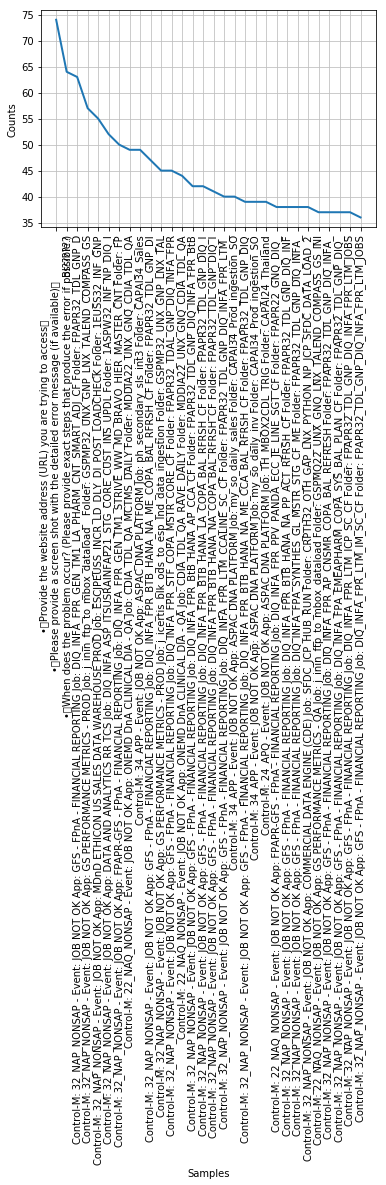

In [99]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [100]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(44990, 44806)
  (0, 22526)	0.1394771522285843
  (0, 18849)	0.20174414174788222
  (0, 4450)	0.4767464429748641
  (0, 22504)	0.20132246026762377
  (0, 40934)	0.2843653124141874
  (0, 43199)	0.21123696259371177
  (0, 41254)	0.1058364038946658
  (0, 40918)	0.26887823872065686
  (0, 17063)	0.21085535111957993
  (0, 6043)	0.6469822295599362
  (1, 17217)	0.1469460639898544
  (1, 5788)	0.16819373767278345
  (1, 21516)	0.14843530084745102
  (1, 27916)	0.24732031825896658
  (1, 32248)	0.11266241199149221
  (1, 32616)	0.14815702052146892
  (1, 12993)	0.1434434191972356
  (1, 32700)	0.27972792866876084
  (1, 19857)	0.239669998582686
  (1, 16235)	0.35163539650395564
  (1, 18716)	0.34854146351734444
  (1, 34816)	0.20809312607448657
  (1, 15685)	0.42989913107079947
  (1, 22493)	0.14717503533302181
  (1, 30572)	0.4255625418246086
  :	:
  (44988, 18028)	0.3310769132075292
  (44988, 23579)	0.30750733839226624
  (44988, 26224)	0.4328774462568097
  (44988, 16764)	0.4234318866555759
  (44988, 16024)	0.403

In [102]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

44990
                                             Description  index
24537  For dim_slt_id=2316, following tasks violated ...  24537
48264  Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...  48264
30708  I have the required user acess rights to AWSAD...  30708
24077  When did this issue begin?:\r\n\r\nWho is this...  24077
12562  GFS-FP&A-FINANCIAL PLANNING TM1 Finance GRM TM...  12562


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [105]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 2].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

original document: 
['For', 'DIM_SLT_ID=203,', 'following', 'task(s)', 'violated', 'the', 'TASK_END_DELAY', 'constraint-\n\nDIM_TASK_ID:', '1636\nTASK_NAME:', 's_m_MENTOR_INT_MNT_LOT_MASTER\nSTART_TIME:', '2019-08-24', '06:02:00', 'UTC\nEND_TIME:', '2019-08-24', '06:03:00', 'UTC\n']


 tokenized and lemmatized document: 
['dim_slt_id', 'follow', 'task', 'violat', 'task_end_delay', 'constraint', 'dim_task_id', 'task_nam', 'start_tim', 'end_tim']


24537    [dim_slt_id, follow, task, violat, task_end_de...
48264    [control, event, onemd, clinic, prod, cdia_rav...
30708    [requir, user, ace, right, awsadwirl, awsadwir...
24077    [issu, begin, affect, mobil, issu, map, defaul...
12562    [financi, plan, financ, prod, gaap, incom, dif...
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [106]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 constraint
1 dim_slt_id
2 follow
3 task
4 task_end_delay
5 violat
6 cdia_rave_load
7 clinic
8 control
9 event
10 folder


In [107]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(35, 1),
 (122, 1),
 (125, 1),
 (152, 1),
 (155, 1),
 (161, 5),
 (176, 1),
 (205, 1),
 (233, 1),
 (266, 1),
 (423, 1),
 (459, 1),
 (469, 2),
 (470, 1),
 (471, 1),
 (472, 1),
 (473, 1),
 (474, 1),
 (475, 1),
 (476, 1)]

In [108]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 35 ("issu") appears 1 time.
Word 122 ("tool") appears 1 time.
Word 125 ("creat") appears 1 time.
Word 152 ("softwar") appears 1 time.
Word 155 ("chang") appears 1 time.
Word 161 ("file") appears 5 time.
Word 176 ("current") appears 1 time.
Word 205 ("work") appears 1 time.
Word 233 ("bold") appears 1 time.
Word 266 ("output") appears 1 time.
Word 423 ("problem") appears 1 time.
Word 459 ("tableau") appears 1 time.
Word 469 ("alteryx") appears 2 time.
Word 470 ("corrupt") appears 1 time.
Word 471 ("place") appears 1 time.
Word 472 ("review") appears 1 time.
Word 473 ("sure") appears 1 time.
Word 474 ("use") appears 1 time.
Word 475 ("visual") appears 1 time.
Word 476 ("workflow") appears 1 time.


In [109]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.3897979378120952),
 (1, 0.36610326418085787),
 (2, 0.3600782695614247),
 (3, 0.374785131814939),
 (4, 0.5407218030161777),
 (5, 0.38926294986371585)]


### Finding out 5 topics using LDA

In [110]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [111]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.060*"task" + 0.055*"follow" + 0.049*"fail" + 0.043*"statu" + 0.043*"dim_task_id"'), (1, '0.022*"access" + 0.019*"http" + 0.019*"user" + 0.014*"error" + 0.012*"attach"'), (2, '0.041*"fail" + 0.038*"error" + 0.024*"idiscov" + 0.021*"start_tim" + 0.021*"end_tim"'), (3, '0.142*"folder" + 0.140*"control" + 0.136*"event" + 0.065*"report" + 0.059*"financi"'), (4, '0.086*"issu" + 0.074*"troubleshoot" + 0.042*"busi" + 0.039*"impact" + 0.039*"step"')]
Topic: 0 
Words: 0.060*"task" + 0.055*"follow" + 0.049*"fail" + 0.043*"statu" + 0.043*"dim_task_id" + 0.042*"dim_slt_id" + 0.037*"violat" + 0.036*"constraint" + 0.036*"task_nam" + 0.023*"end_tim"
Topic: 1 
Words: 0.022*"access" + 0.019*"http" + 0.019*"user" + 0.014*"error" + 0.012*"attach" + 0.012*"data" + 0.010*"request" + 0.010*"need" + 0.009*"report" + 0.009*"unabl"
Topic: 2 
Words: 0.041*"fail" + 0.038*"error" + 0.024*"idiscov" + 0.021*"start_tim" + 0.021*"end_tim" + 0.020*"task_nam" + 0.019*"dim_task_id" + 0.018*"code" + 0.016*"statu" 

In [112]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [113]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

In [114]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [115]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(104, 5)
(5, 104)


In [116]:
df_lda

,abl,access,account,affect,ajsroot,analyt,apach,applic,aspac,assign,...,tri,troubleshoot,unabl,updat,user,violat,visibl,vison,websit,work
0,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.036701,0.000000,0.000000,0.000000,0.000000
1,0.005739,0.021623,0.00782,0.000000,0.0000,0.000000,0.000000,0.006501,0.000000,0.000000,...,0.006289,0.000000,0.008787,0.006082,0.018740,0.000000,0.000000,0.000000,0.005762,0.006709
2,0.000000,0.000000,0.00000,0.000000,0.0128,0.000000,0.011964,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.0000,0.006241,0.000000,0.000000,0.032172,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004739,0.004153,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.037858,0.0000,0.000000,0.000000,0.000000,0.000000,0.005926,...,0.000000,0.073737,0.000000,0.000000,0.013389,0.000000,0.000000,0.000000,0.000000,0.000000


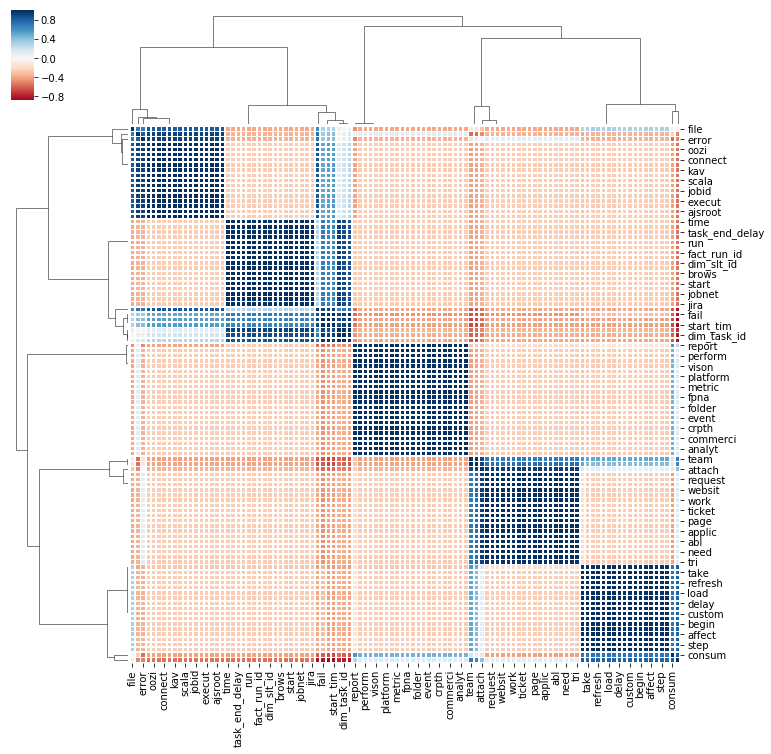

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [118]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [119]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05,random_state=42)
    return X_train, X_test, y_train, y_test

In [120]:

vocab_size = len(tokenizer.word_index) + 1

## Deep Learning Model Simple

In [121]:
from sklearn.externals import joblib

In [122]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Training Model to predict Priority of the ticket

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 128)          5661312   
_________________________________________________________________
flatten_2 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 7,709,410
Trainable params: 7,709,410
Non-trainable params: 0
_________________________________________________________________
Train on 32055 samples, validate on 10685 samples
Epoch 1/10
32055/32055 [==============================] - 28s 871us/step - loss: 0

['model-simple_prt.pkl']

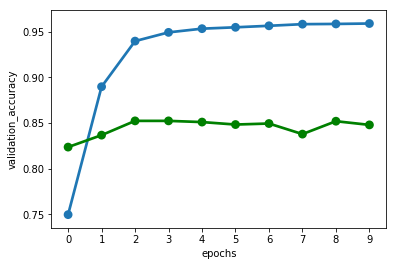

In [123]:
X_train, X_test, y_train, y_test = data_set_split(y_prt)

model_file = 'weights-simple_ptr.hdf5'
model = model_training(num_class_prt, model_file)
joblib.dump(model,'model-simple_prt.pkl')

In [124]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.8408888888888889

In [125]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [126]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [127]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
#This should be adjusted to the Predictor
encoder.fit(data.Priority.values)
text_labels = encoder.classes_ 


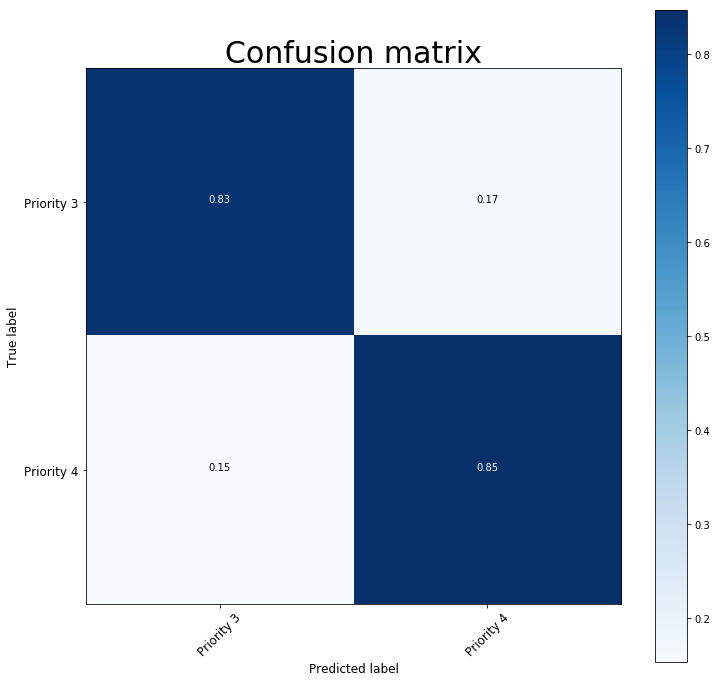

In [128]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [129]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    x = LSTM(64)(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=20, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


### Training Predictor for Priority using LSTM RNN 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 128)          5661312   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 5,712,866
Trainable params: 5,712,866
Non-trainable params: 0
_________________________________________________________________
Train on 32055 samples, validate on 10685 samples
Epoch 1/20
32055/32055 [==============================] - 247s 8ms/step - loss: 0.

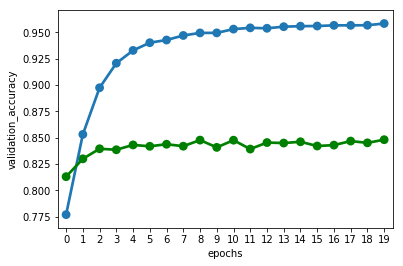

In [130]:
X_train, X_test, y_train, y_test = data_set_split(y_prt)
model_lstm = lstm_model_training(num_class_prt,"weights_prt.hdf5")
joblib.dump(model_lstm,'model_ptr.pkl')
predicted = model_lstm.predict(X_test)

In [131]:
predicted
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.8373333333333334

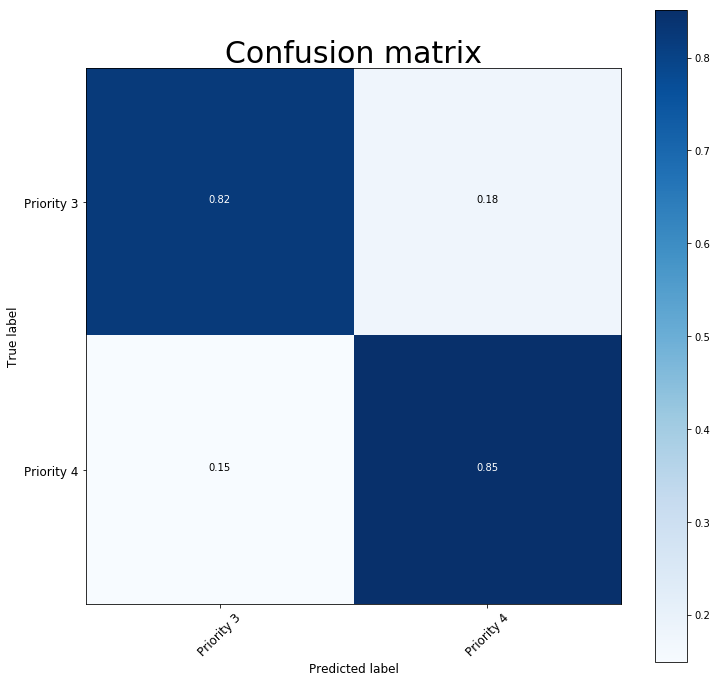

In [132]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [133]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1121
           1       0.83      0.85      0.84      1129

   micro avg       0.84      0.84      0.84      2250
   macro avg       0.84      0.84      0.84      2250
weighted avg       0.84      0.84      0.84      2250

